In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas_datareader.data as web
import talib as ta

# import pydot
import pydotplus 
from IPython.display import Image
from sklearn import tree
import xgboost as xgb


from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, \
RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from sklearn.datasets import load_iris


%matplotlib inline
# plt.style.use('seaborn')
%cd C:\Users\yo\Documents\ML_and_Python\ML_and_Python_books\ISLR\ISLR-python\Notebooks\Data

C:\Users\yo\Documents\ML_and_Python\ML_and_Python_books\ISLR\ISLR-python\Notebooks\Data


In [6]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=class_names, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)


### 8.1.1 Regression Trees

In [7]:
hitters = pd.read_csv('Hitters.csv').dropna()
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 45.2+ KB


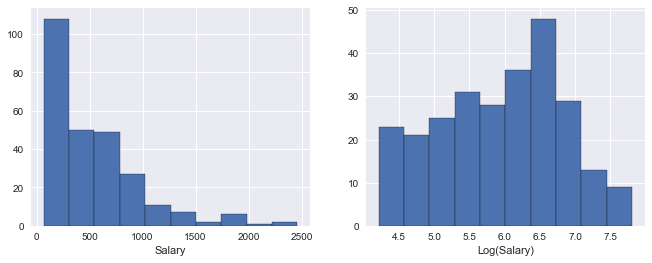

In [8]:
X = hitters[['Years', 'Hits']].as_matrix()
y = np.log(hitters.Salary.as_matrix())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(hitters.Salary.as_matrix(),edgecolor='black')
ax1.set_xlabel('Salary')
ax2.hist(y,edgecolor='black')
ax2.set_xlabel('Log(Salary)');

In [9]:
regr = tree.DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=3, min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

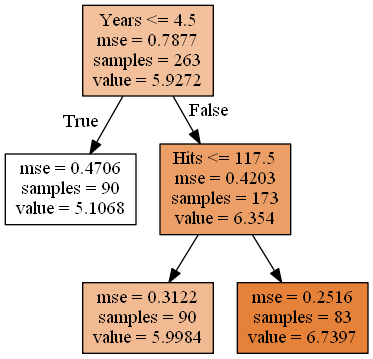

In [10]:
graph = print_tree(regr, features=['Years', 'Hits'])
Image(graph.create_png())


In [11]:
# the "value" is the log of the Salary since we transformed the original Salary with Log Transform, therefore in order to
# get the predicted value for Salary we need to find exponent of the "value"
np.exp(5.107)

165.17408858074765

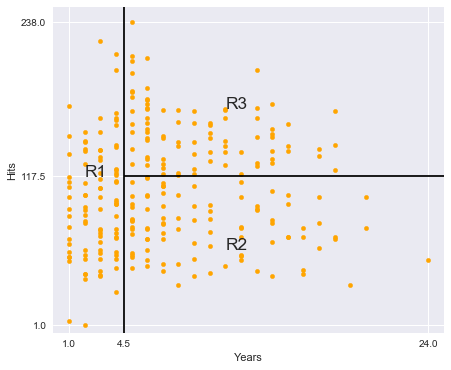

In [12]:
hitters.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([1, 4.5, 24])
plt.yticks([1, 117.5, 238])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large');

## Lab 8.3.1 Fitting Classification Trees

In [13]:
carseats_df = pd.read_csv("Carseats.csv",index_col=0)
carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
5,4.15,141,64,3,340,128,Bad,38,13,Yes,No


(array([  6.,  16.,  47.,  83.,  89.,  79.,  40.,  29.,   8.,   3.]),
 array([  0.   ,   1.627,   3.254,   4.881,   6.508,   8.135,   9.762,
         11.389,  13.016,  14.643,  16.27 ]),
 <a list of 10 Patch objects>)

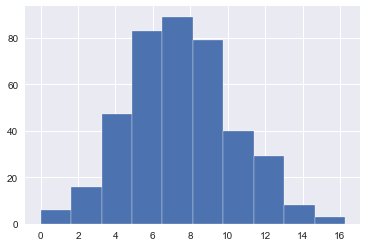

In [14]:
# Convert other string variables to numeric
carseats_df["ShelveLoc"] = pd.factorize(carseats_df["ShelveLoc"])[0]
carseats_df["Urban"] = pd.factorize(carseats_df["Urban"])[0]
carseats_df["US"] = pd.factorize(carseats_df["US"])[0]
# We want to add a binary response variable High (High Sales). We build a histogram to 
# determine the cut point.
plt.hist(carseats_df["Sales"],edgecolor='white')

In [15]:
# create a binary response variable HighSales and add to dataframe
carseats_df["High"] = carseats_df["Sales"].map(lambda x: 0 if x <= 8 else 1)
carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
1,9.50,138,73,11,276,120,0,42,17,0,0,1
2,11.22,111,48,16,260,83,1,65,10,0,0,1
3,10.06,113,35,10,269,80,2,59,12,0,0,1
4,7.40,117,100,4,466,97,2,55,14,0,0,0
5,4.15,141,64,3,340,128,0,38,13,0,1,0


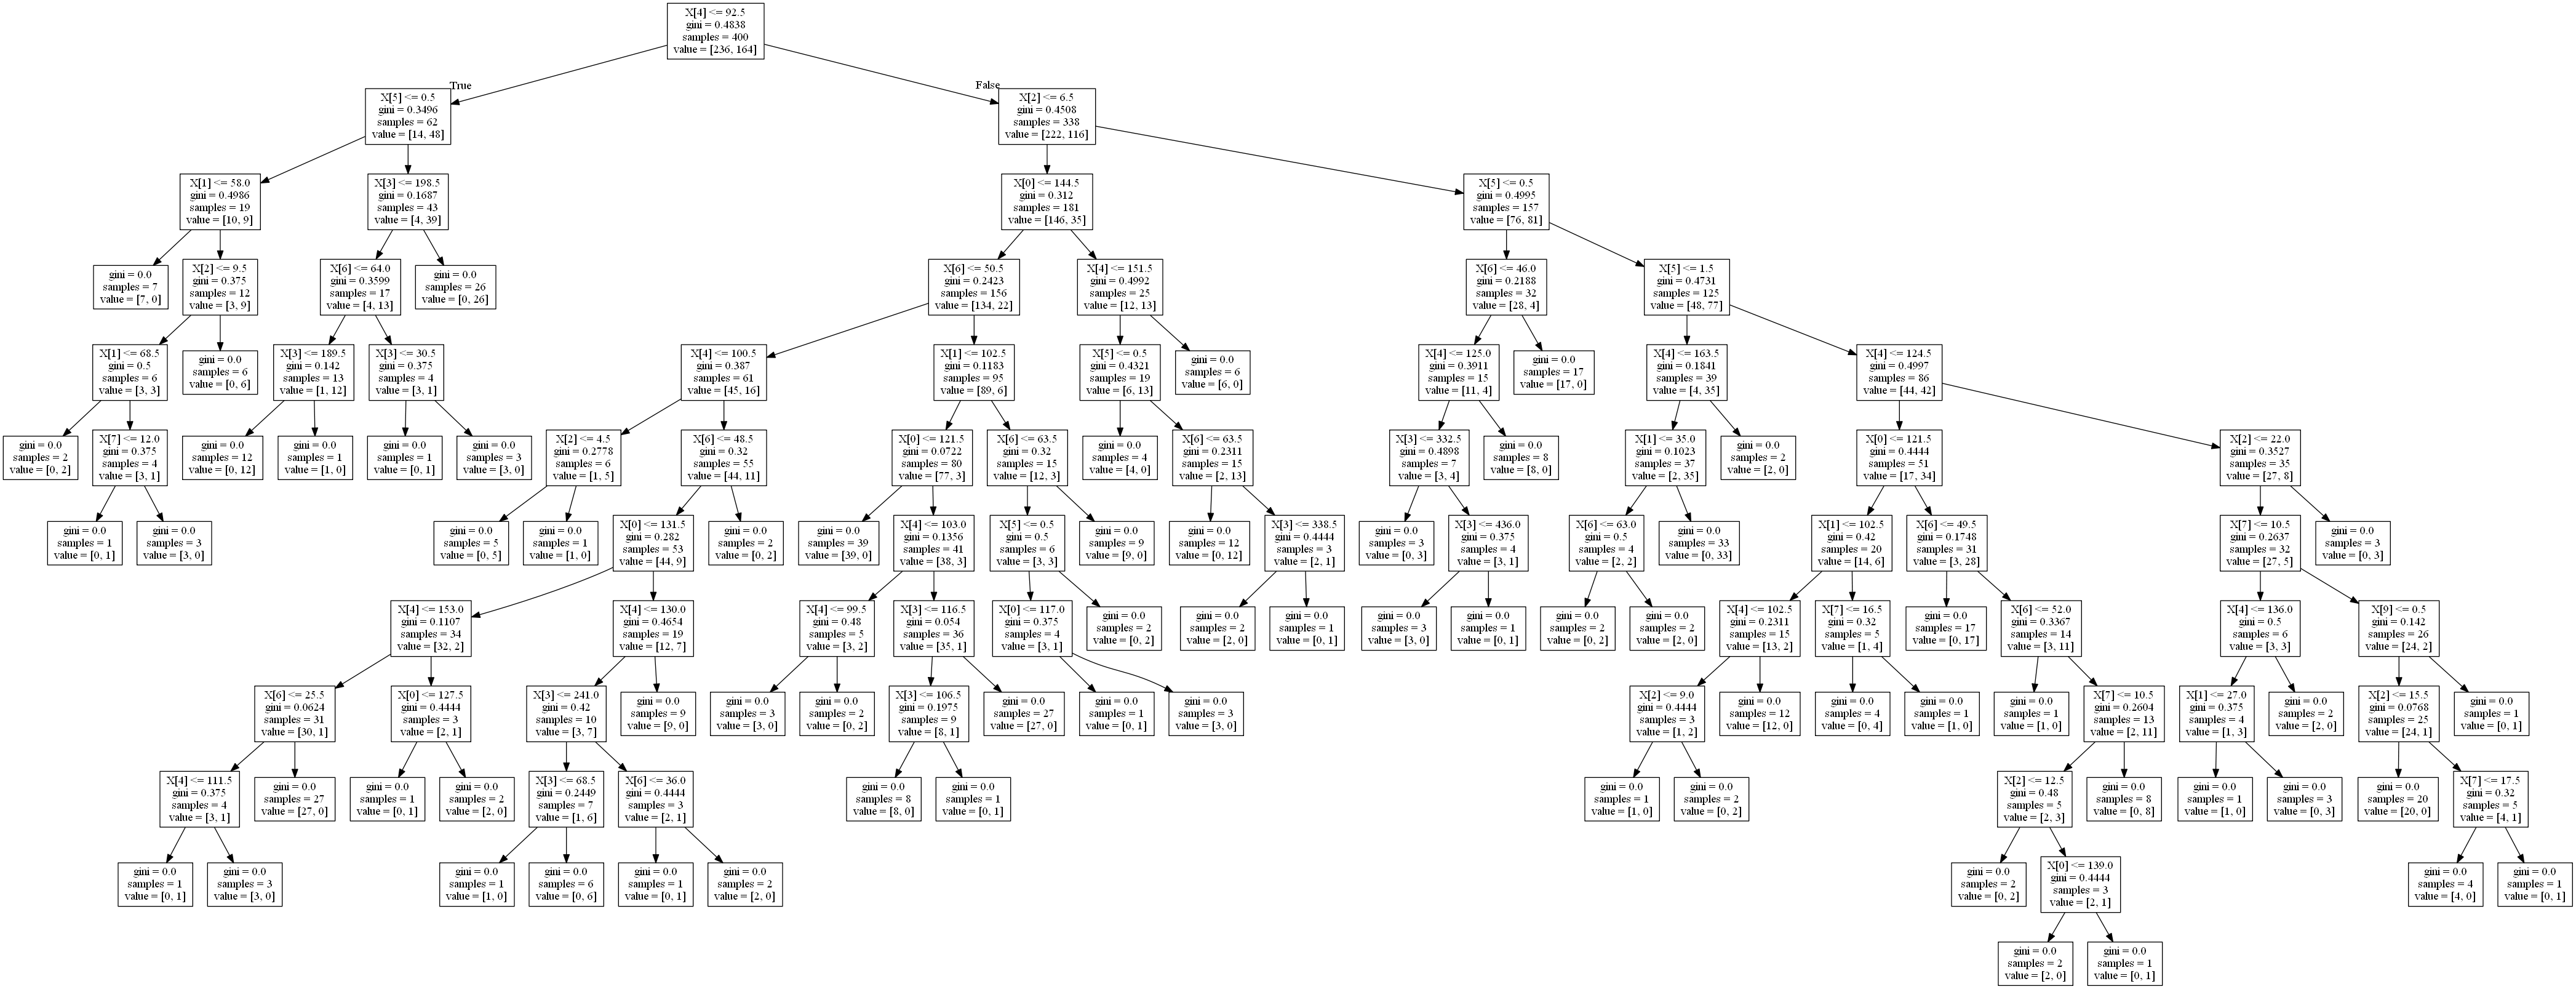

In [16]:
# fit a decision tree to predict High from the data. We remove Sales because High is
# derived from Sales and is thus correlated to the response
collist = [x for x in carseats_df.columns if x not in ('Sales', 'High')]
clf = DecisionTreeClassifier()
X = carseats_df[collist]
y = carseats_df["High"]
clf.fit(X, y)

# Visualize tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
print(graph)
Image(graph.create_png())

In [17]:
Xr, Xt, yr, yt = train_test_split(X, y, train_size=250, test_size=150, random_state=42)
clf = DecisionTreeClassifier()
clf.fit(Xr, yr)
ypred = clf.predict(Xt)
(confusion_matrix(yt, ypred), accuracy_score(yt, ypred))

(array([[60, 22],
        [26, 42]]), 0.68000000000000005)

Pruning can reduce overfitting. Scikit-Learn DecisionTree classifier does not support pruning currently, but one can set the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem. Here we will use cross validation with different max depths to optimize the tree.

             precision    recall  f1-score   support

          0       0.83      0.77      0.80        13
          1       0.77      0.83      0.80        12

avg / total       0.80      0.80      0.80        25



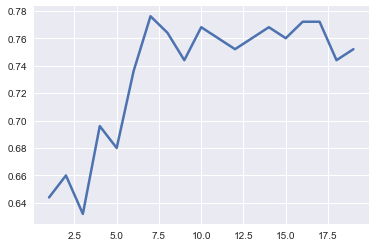

In [18]:
kfold = KFold(n_splits=10)
accs = []
max_depths = range(1, 20)
max_depth_list = []
for max_depth in max_depths:
    k_accs = []
    for train, test in kfold.split(Xr):
        Xtrain, Xtest, ytrain, ytest = Xr.iloc[train], Xr.iloc[test], yr.iloc[train], yr.iloc[test]
# if something goes wrong with the split, check option of .values()
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        k_accs.append(accuracy_score(ytest, ypred))
        max_depth_list.append(max_depth)
    accs.append(np.mean(k_accs))
# plot the accuracies as a function of max_depth

print(classification_report(ytest, ypred))
plt.plot(max_depths, accs, linewidth=2.5)

In [19]:
clf = DecisionTreeClassifier(max_depth=17)
clf.fit(Xr, yr)
ypred = clf.predict(Xt)
confusion_matrix(yt, ypred), accuracy_score(yt, ypred)
print(classification_report(yt, ypred))

             precision    recall  f1-score   support

          0       0.73      0.74      0.73        82
          1       0.68      0.66      0.67        68

avg / total       0.71      0.71      0.71       150



### Random Forests ###

Random Forests build lots of bushy trees, and then average them to reduce the variance. We will use Random Forests to predict the same Sales high or low

             precision    recall  f1-score   support

          0       0.87      1.00      0.93        13
          1       1.00      0.83      0.91        12

avg / total       0.93      0.92      0.92        25
 True


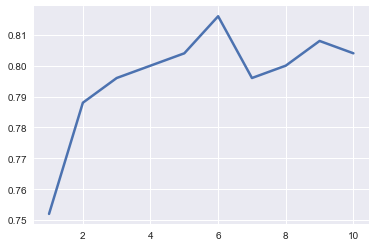

In [20]:
kfold = KFold(n_splits=10)
oob_scores = []
mses = []
num_feats = range(1, 11)
accs = []


for num_feat in num_feats:
    k_accs = []
    for train, test in kfold.split(Xr):
        Xtrain, Xtest, ytrain, ytest = Xr.iloc[train], Xr.iloc[test], yr.iloc[train], yr.iloc[test]
# if something goes wrong with the split, check option of .values()
        clf = RandomForestClassifier(n_estimators=500, oob_score=True, max_features=num_feat)
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        k_accs.append(accuracy_score(ytest, ypred))

    accs.append(np.mean(k_accs))
# plot the accuracies as a function of max_depth

print(classification_report(ytest, ypred), clf.oob_score)
plt.plot(num_feats, accs, linewidth=2.5)


In [21]:
# training and testing using the best max_features=7
clf = RandomForestClassifier(n_estimators=500, oob_score=True, max_features=7)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
k_accs.append(accuracy_score(ytest, ypred))

accs.append(np.mean(k_accs))
# plot the accuracies as a function of max_depth

print(classification_report(ytest, ypred), clf.oob_score)

             precision    recall  f1-score   support

          0       0.87      1.00      0.93        13
          1       1.00      0.83      0.91        12

avg / total       0.93      0.92      0.92        25
 True


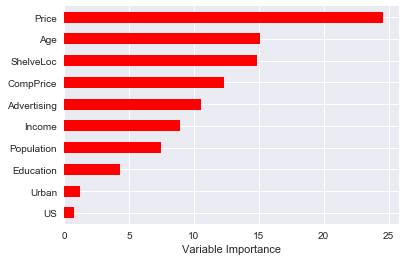

In [22]:
Importance = pd.DataFrame({'Importance':clf.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### Boosting ###

Boosting builds lots of small trees. Unlike Random Forests, each tree tries to make up for the deficiencies in the current ensemble. With Boosting, the number of trees is a tuning parameter. Using the same train/test split, we plot the variance of MSE against the number of trees.

In [23]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(Xtrain, ytrain)
clf.score(Xtest, ytest)   

0.92000000000000004

[0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996, 0.95999999999999996]


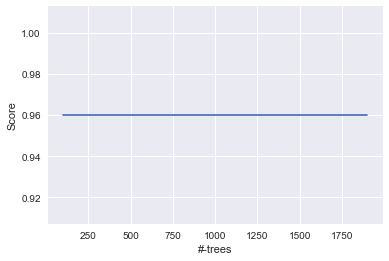

In [24]:
num_trees = range(100, 2000, 100)
scores = []
for num_tree in num_trees:
    clf = GradientBoostingClassifier(n_estimators=num_tree).fit(Xtrain, ytrain)
    ypred = clf.predict(Xtest)
    scores.append(accuracy_score(ytest, ypred))

plt.plot(num_trees, scores)
plt.xlabel("#-trees")
plt.ylabel("Score")
print(scores)

In [25]:
kfold = KFold(n_splits=10)
num_trees = range(100, 2000, 100)
scores = []
for train, test in kfold.split(Xr):
    Xtrain, Xtest, ytrain, ytest = Xr.iloc[train], Xr.iloc[test], yr.iloc[train], yr.iloc[test]
# if something goes wrong with the split, check option of .values()
    for num_tree in num_trees:
        clf = GradientBoostingClassifier(n_estimators=num_tree).fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        scores.append(np.mean(accuracy_score(ytest, ypred)))

# plt.plot(num_trees, scores)
# plt.xlabel("#-trees")
# plt.ylabel("Score")
# print(scores)
    
# plot the accuracies as a function of max_depth

print(classification_report(ytest, ypred), accuracy_score(ytest, ypred))
# plt.plot(num_feats, accs, linewidth=2.5)


             precision    recall  f1-score   support

          0       0.93      1.00      0.96        13
          1       1.00      0.92      0.96        12

avg / total       0.96      0.96      0.96        25
 0.96


### Decision Trees applied to smarket data

In [2]:
smarket = pd.read_csv('smarket.csv', index_col='Year', usecols=['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'], parse_dates=True)
smarket.Direction = pd.factorize(smarket.Direction)[0]
smarket.drop(['Today'], axis=1, inplace=True)
smarket.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Direction
Year,,,,,,,
2001-01-01,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0
2001-01-01,0.959,0.381,-0.192,-2.624,-1.055,1.2965,0
2001-01-01,1.032,0.959,0.381,-0.192,-2.624,1.4112,1
2001-01-01,-0.623,1.032,0.959,0.381,-0.192,1.2760,0
2001-01-01,0.614,-0.623,1.032,0.959,0.381,1.2057,0


In [3]:
# fit a decision tree to predict Direction from the data. 
collist = [x for x in smarket.columns if x not in ('Direction')]
clf = DecisionTreeClassifier()
X = smarket[collist]
y = smarket.Direction
clf.fit(X, y)
ypred = clf.predict(X)

# Visualize tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
print(graph)
# Image(graph.create_png())

In [4]:
# Decirion Tree Classifier fit to and tested on the same data
confusion_matrix(y, ypred), accuracy_score(y, ypred)

(array([[648,   0],
        [  0, 602]]), 1.0)

In [29]:
# Decirion Tree Classifier fit to and tested on a split of data 70% train and 30% test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=42)
clf = DecisionTreeClassifier()
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
(confusion_matrix(ytest, ypred), accuracy_score(ytest, ypred))

(array([[ 97,  87],
        [105,  86]]), 0.48799999999999999)

             precision    recall  f1-score   support

          0       0.60      0.43      0.50        72
          1       0.44      0.60      0.51        53

avg / total       0.53      0.50      0.50       125



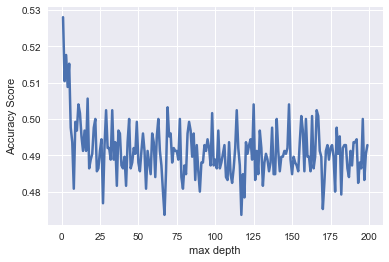

In [30]:
# Using different max_depth and applying kFold CV
kfold = KFold(n_splits=10)
accs = []
max_depths = range(1, 20)
max_depth_list = []
max_depths = range(1, 200)
for max_depth in max_depths:
    k_accs = []
    for train, test in kfold.split(X):
        Xtrain, Xtest, ytrain, ytest = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
# if something goes wrong with the split, check option of .values()
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        k_accs.append(accuracy_score(ytest, ypred))
        max_depth_list.append(max_depth)
    accs.append(np.mean(k_accs))
# plot the accuracies as a function of max_depth

print(classification_report(ytest, ypred))
plt.plot(max_depths, accs, linewidth=2.5)
plt.xlabel("max depth")
plt.ylabel("Accuracy Score")

In [31]:
# seems to be that the depth on 0 is the best option
kfold = KFold(n_splits=10)
for train, test in kfold.split(X):
    Xtrain, Xtest, ytrain, ytest = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
# if something goes wrong with the split, check option of .values()
    clf = DecisionTreeClassifier()
    clf.fit(Xtrain, ytrain)
    ypred = clf.predict(Xtest)
print(classification_report(ytest, ypred), accuracy_score(ytest, ypred))


             precision    recall  f1-score   support

          0       0.57      0.40      0.47        72
          1       0.42      0.58      0.49        53

avg / total       0.51      0.48      0.48       125
 0.48


### Random Forests applied to smarket data

             precision    recall  f1-score   support

        0.0       0.67      0.67      0.67        79
        1.0       0.72      0.72      0.72        94

avg / total       0.70      0.70      0.70       173
 True


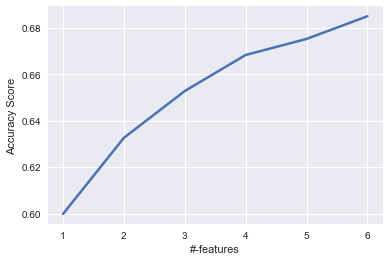

In [57]:
kfold = KFold(n_splits=10)
oob_scores = []
mses = []
num_feats = range(1, 7)
accs = []


for num_feat in num_feats:
    k_accs = []
    for train, test in kfold.split(X):
        Xtrain, Xtest, ytrain, ytest = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
# if something goes wrong with the split, check option of .values()
        clf = RandomForestClassifier(n_estimators=500, oob_score=True, max_features=num_feat)
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        k_accs.append(accuracy_score(ytest, ypred))

    accs.append(np.mean(k_accs))
# plot the accuracies as a function of max_depth

print(classification_report(ytest, ypred), clf.oob_score)
plt.plot(num_feats, accs, linewidth=2.5)
plt.xlabel('#-features')
plt.ylabel('Accuracy Score')

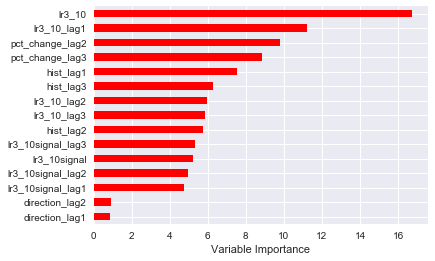

In [59]:
Importance = pd.DataFrame({'Importance':clf.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### Boosting applied to smarket data

In [34]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(Xtrain, ytrain)
clf.score(Xtest, ytest) 

0.48799999999999999

             precision    recall  f1-score   support

          0       0.55      0.36      0.44        72
          1       0.41      0.60      0.49        53

avg / total       0.49      0.46      0.46       125



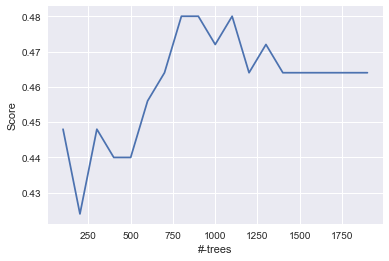

In [35]:
num_trees = range(100, 2000, 100)
scores = []
for num_tree in num_trees:
    clf = GradientBoostingClassifier(n_estimators=num_tree).fit(Xtrain, ytrain)
    ypred = clf.predict(Xtest)
    scores.append(accuracy_score(ytest, ypred))

print(classification_report(ytest, ypred))
plt.plot(num_trees, scores)
plt.xlabel("#-trees")
plt.ylabel("Score")


### Using AdaBoost classifier on smarket

             precision    recall  f1-score   support

        0.0       0.86      0.72      0.79        79
        1.0       0.79      0.90      0.85        94

avg / total       0.83      0.82      0.82       173



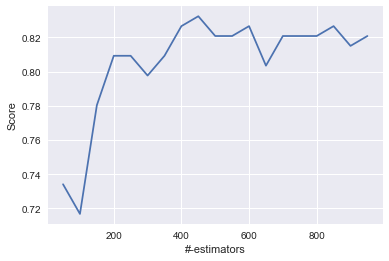

In [55]:
num_estimators = range(50, 1000, 50)
scores = []
for num_estimator in num_estimators:
    clf = AdaBoostClassifier(n_estimators=num_estimator).fit(Xtrain, ytrain)
    ypred = clf.predict(Xtest)
    scores.append(accuracy_score(ytest, ypred))

print(classification_report(ytest, ypred))
plt.plot(num_estimators, scores)
plt.xlabel("#-estimators")
plt.ylabel("Score")
# print(scores)

             precision    recall  f1-score   support

        0.0       0.82      0.67      0.74        79
        1.0       0.76      0.87      0.81        94

avg / total       0.78      0.78      0.78       173



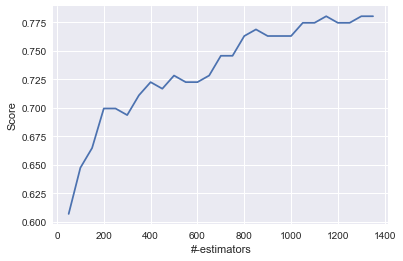

In [56]:
params = {'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
num_estimators = range(50, 1400, 50)
scores = []
for num_estimator in num_estimators:
    clf = GradientBoostingClassifier(n_estimators=num_estimator, **params).fit(Xtrain, ytrain)
    ypred = clf.predict(Xtest)
    scores.append(accuracy_score(ytest, ypred))

print(classification_report(ytest, ypred))
plt.plot(num_estimators, scores)
plt.xlabel("#-estimators")
plt.ylabel("Score")
# print(scores)



In [ ]:
# params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
#           'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
# clf = ensemble.GradientBoostingClassifier(**params)

             precision    recall  f1-score   support

          0       0.57      0.35      0.43        72
          1       0.42      0.64      0.51        53

avg / total       0.51      0.47      0.46       125



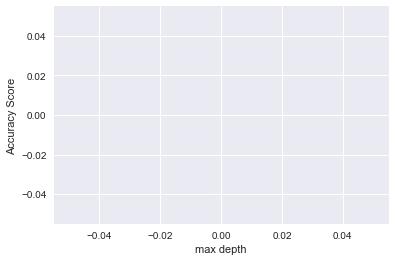

In [8]:
# Using different max_depth and applying kFold CV
params = {'n_estimators': 1000, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
kfold = KFold(n_splits=10)
accs = []
max_depths = range(1, 1)
for max_depth in max_depths:
    k_accs = []
    for train, test in kfold.split(X):
        Xtrain, Xtest, ytrain, ytest = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
# if something goes wrong with the split, check option of .values()
        clf = GradientBoostingClassifier(max_depth=max_depth, **params)
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        k_accs.append(accuracy_score(ytest, ypred))
        max_depth_list.append(max_depth)
    accs.append(np.mean(k_accs))
# plot the accuracies as a function of max_depth

print(classification_report(ytest, ypred))
plt.plot(max_depths, accs, linewidth=2.5)
plt.xlabel("max depth")
plt.ylabel("Accuracy Score")

### eXGboost classifier

             precision    recall  f1-score   support

          0       0.62      0.36      0.46        72
          1       0.45      0.70      0.54        53

avg / total       0.55      0.50      0.49       125



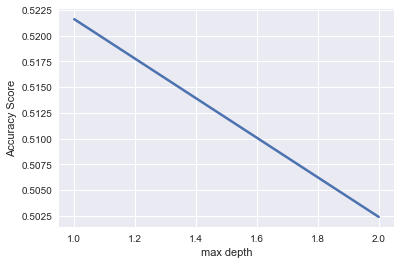

In [17]:
# Using different max_depth and applying kFold CV and eXBoost
params = {'n_estimators': 1000, 'subsample': 0.5, 'learning_rate': 0.01}
kfold = KFold(n_splits=10)
accs = []
max_depth_list = []
max_depths = range(1, 3)
for max_depth in max_depths:
    k_accs = []
    for train, test in kfold.split(X):
        Xtrain, Xtest, ytrain, ytest = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
# if something goes wrong with the split, check option of .values()
        clf = xgb.XGBClassifier(max_depth=max_depth, **params)
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        k_accs.append(accuracy_score(ytest, ypred))
        max_depth_list.append(max_depth)
    accs.append(np.mean(k_accs))
# plot the accuracies as a function of max_depth

print(classification_report(ytest, ypred))
plt.plot(max_depths, accs, linewidth=2.5)
plt.xlabel("max depth")
plt.ylabel("Accuracy Score")

In [11]:
xc = xgb.XGBClassifier()
xc.fit(X,y)
accuracy_score(y, xc.predict(X))

0.79039999999999999

In [133]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 2, 27)
gspc2 = web.DataReader("^GSPC", 'yahoo', start, end)
gspc2.rename(columns={'Adj Close' :'Adj_Close'}, inplace=True)
gspc2['pct_change'] = gspc2['Adj_Close'].pct_change()

gspc2['pct_change_lag1'] = gspc2['pct_change'].shift(1)


gspc2['pct_change_lag2'] = gspc2['Adj_Close'].pct_change(2)
gspc2['pct_change_lag3'] = gspc2['Adj_Close'].pct_change(3)
gspc2['pct_change_lag4'] = gspc2['Adj_Close'].pct_change(4)
gspc2['pct_change_lag5'] = gspc2['Adj_Close'].pct_change(5)
gspc2['pct_change_lag6'] = gspc2['Adj_Close'].pct_change(6)
gspc2['pct_change_lag7'] = gspc2['Adj_Close'].pct_change(7)
gspc2['pct_change_lag8'] = gspc2['Adj_Close'].pct_change(8)

gspc2['pct_change_lag2'] = gspc2['pct_change_lag2'].shift(1)
gspc2['pct_change_lag3'] = gspc2['pct_change_lag3'].shift(1)
gspc2['pct_change_lag4'] = gspc2['pct_change_lag4'].shift(1)
gspc2['pct_change_lag5'] = gspc2['pct_change_lag5'].shift(1)
gspc2['pct_change_lag6'] = gspc2['pct_change_lag6'].shift(1)
gspc2['pct_change_lag7'] = gspc2['pct_change_lag7'].shift(1)
gspc2['pct_change_lag8'] = gspc2['pct_change_lag8'].shift(1)


gspc2['day_lag1'] = gspc2['pct_change'].shift(1)
gspc2['day_lag2'] = gspc2['pct_change'].shift(2)
gspc2['day_lag3'] = gspc2['pct_change'].shift(3)
gspc2['day_lag4'] = gspc2['pct_change'].shift(4)
gspc2['day_lag5'] = gspc2['pct_change'].shift(5)
gspc2['day_lag6'] = gspc2['pct_change'].shift(6)
gspc2['day_lag7'] = gspc2['pct_change'].shift(7)
gspc2['day_lag8'] = gspc2['pct_change'].shift(8)
# gspc2['pct_change1'] = gspc2['Adj_Close'].shift(-1) / gspc2['Adj_Close']  - 1
# gspc2['pct_change2'] = gspc2['Adj_Close'].shift(-2) / gspc2['Adj_Close']  - 1
# gspc2['pct_change3'] = gspc2['Adj_Close'].shift(-3) / gspc2['Adj_Close']  - 1
# gspc2['pct_change4'] = gspc2['Adj_Close'].shift(-4) / gspc2['Adj_Close']  - 1
# gspc2['pct_change5'] = gspc2['Adj_Close'].shift(-5) / gspc2['Adj_Close']  - 1
# gspc2['pct_change6'] = gspc2['Adj_Close'].shift(-6) / gspc2['Adj_Close']  - 1
# gspc2['pct_change7'] = gspc2['Adj_Close'].shift(-7) / gspc2['Adj_Close']  - 1
# gspc2['pct_change8'] = gspc2['Adj_Close'].shift(-8) / gspc2['Adj_Close']  - 1

# gspc2 = gspc2.ix[(gspc2['pct_change'] > 0.0200)]
gspc2['lr3_10'], gspc2['lr3_10signal'], gspc2['hist'] = ta.MACDEXT(gspc2.Adj_Close.values, fastperiod=3, fastmatype=0, slowperiod=10, slowmatype=0, signalperiod=16, signalmatype=0)
gspc2['lr3_10_lag1'] = gspc2.lr3_10.shift(1)
gspc2['lr3_10_lag2'] = gspc2.lr3_10.shift(2)
gspc2['lr3_10_lag3'] = gspc2.lr3_10.shift(3)
gspc2['lr3_10_lag4'] = gspc2.lr3_10.shift(4)
gspc2['lr3_10_lag5'] = gspc2.lr3_10.shift(5)
gspc2['lr3_10signal_lag1'] = gspc2.lr3_10signal.shift(1)
gspc2['lr3_10signal_lag2'] = gspc2.lr3_10signal.shift(2)
gspc2['lr3_10signal_lag3'] = gspc2.lr3_10signal.shift(3)
gspc2['lr3_10signal_lag4'] = gspc2.lr3_10signal.shift(4)
gspc2['lr3_10signal_lag5'] = gspc2.lr3_10signal.shift(5)
gspc2['hist_lag1'] = gspc2['hist'].shift(1)
gspc2['hist_lag2'] = gspc2['hist'].shift(2)
gspc2['hist_lag3'] = gspc2['hist'].shift(3)
gspc2['hist_lag4'] = gspc2['hist'].shift(4)
gspc2['hist_lag5'] = gspc2['hist'].shift(5)
gspc2['rsi14'] = ta.RSI(gspc2.Adj_Close.values, timeperiod=14)
gspc2['rsi14_lag1'] = gspc2.rsi14.shift(1)
gspc2['rsi14_lag2'] = gspc2.rsi14.shift(2)
gspc2['rsi14_lag3'] = gspc2.rsi14.shift(3)
gspc2['rsi14_lag4'] = gspc2.rsi14.shift(4)
gspc2['rsi14_lag5'] = gspc2.rsi14.shift(5)
# gspc2['upperband'], gspc2['middleband'], gspc2['lowerband'] = ta.BBANDS(gspc2.Adj_Close.values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
# # BB crossed down and up categorical labels
# gspc2.ix[(gspc2['Adj_Close'] <= gspc2['lowerband']) , 'crossed_down'] = 1
# gspc2.ix[(gspc2['Adj_Close'] > gspc2['lowerband']) , 'crossed_down'] = 0
# gspc2.ix[(gspc2['Adj_Close'] >= gspc2['upperband']) , 'crossed_up'] = 1
# gspc2.ix[(gspc2['Adj_Close'] < gspc2['upperband']) , 'crossed_up'] = 0
gspc2['mama'], gspc2['fama'] = ta.MAMA(gspc2.Adj_Close.values, fastlimit=0.5, slowlimit=0.05)
gspc2['hilbert'] = ta.HT_TRENDLINE(gspc2.Adj_Close.values)
gspc2['atr'] = ta.ATR(gspc2.High.values, gspc2.Low.values, gspc2.Close.values, timeperiod=14)
gspc2.ix[gspc2['pct_change'] >= 0, 'direction'] = 1
gspc2.ix[gspc2['pct_change'] < 0, 'direction'] = 0
gspc2['direction_lag1'] = gspc2['direction'].shift(1)
gspc2['direction_lag2'] = gspc2['direction'].shift(2)
gspc2['direction_lag3'] = gspc2['direction'].shift(3)
gspc2['direction_lag4'] = gspc2['direction'].shift(4)
gspc2['direction_lag5'] = gspc2['direction'].shift(5)
gspc2['direction_lag6'] = gspc2['direction'].shift(6)
gspc2['direction_lag7'] = gspc2['direction'].shift(7)
gspc2['direction_lag8'] = gspc2['direction'].shift(8)

# gspc2.ix[gspc2['pct_change2'] >= 0, 'pct_change2_yn'] = 1
# gspc2.ix[gspc2['pct_change2'] < 0, 'pct_change2_yn'] = 0
# gspc2.ix[gspc2['pct_change3'] >= 0, 'pct_change3_yn'] = 1
# gspc2.ix[gspc2['pct_change3'] < 0, 'pct_change3_yn'] = 0
# gspc2.ix[gspc2['pct_change4'] >= 0, 'pct_change4_yn'] = 1
# gspc2.ix[gspc2['pct_change4'] < 0, 'pct_change4_yn'] = 0
# gspc2.ix[gspc2['pct_change5'] >= 0, 'pct_change5_yn'] = 1
# gspc2.ix[gspc2['pct_change5'] < 0, 'pct_change5_yn'] = 0
# gspc2.ix[gspc2['pct_change6'] >= 0, 'pct_change6_yn'] = 1
# gspc2.ix[gspc2['pct_change6'] < 0, 'pct_change6_yn'] = 0
# gspc2.ix[gspc2['pct_change7'] >= 0, 'pct_change7_yn'] = 1
# gspc2.ix[gspc2['pct_change7'] < 0, 'pct_change7_yn'] = 0

gspc2.head(20)
gspc2.dropna(axis=0,inplace=True)
# gspc2[pd.isnull(gspc2).any(axis=1)]
gspc2['High_shift2'] = gspc2.High.shift(2)
gspc2['Low_shift2'] = gspc2.Low.shift(2)
gspc2['Close_shift2'] = gspc2.Close.shift(2)
gspc2['Open_dev_close_shift2'] = gspc2.Open / gspc2.Close_shift2
gspc2['High_dev_close_shift2'] = gspc2.Open / gspc2.High_shift2
gspc2['Low_dev_close_shift2'] = gspc2.Open / gspc2.Low_shift2

gspc3 = gspc2[['Open', 'Volume' , 'pct_change_lag2', 'pct_change_lag3', 'direction_lag1', 'direction_lag2'\
        ,'lr3_10_lag1', 'lr3_10_lag2', 'lr3_10_lag3', 'lr3_10signal_lag1'\
       ,'lr3_10signal_lag2', 'lr3_10signal_lag3', 'hist_lag1', 'hist_lag2', 'hist_lag3',  'direction', 'Low_shift2', 'Close_shift2',
       'Open_dev_close_shift2', 'High_dev_close_shift2',
       'Low_dev_close_shift2']]


In [134]:
gspc2.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj_Close', 'pct_change',
       'pct_change_lag1', 'pct_change_lag2', 'pct_change_lag3',
       'pct_change_lag4', 'pct_change_lag5', 'pct_change_lag6',
       'pct_change_lag7', 'pct_change_lag8', 'day_lag1', 'day_lag2',
       'day_lag3', 'day_lag4', 'day_lag5', 'day_lag6', 'day_lag7', 'day_lag8',
       'lr3_10', 'lr3_10signal', 'hist', 'lr3_10_lag1', 'lr3_10_lag2',
       'lr3_10_lag3', 'lr3_10_lag4', 'lr3_10_lag5', 'lr3_10signal_lag1',
       'lr3_10signal_lag2', 'lr3_10signal_lag3', 'lr3_10signal_lag4',
       'lr3_10signal_lag5', 'hist_lag1', 'hist_lag2', 'hist_lag3', 'hist_lag4',
       'hist_lag5', 'rsi14', 'rsi14_lag1', 'rsi14_lag2', 'rsi14_lag3',
       'rsi14_lag4', 'rsi14_lag5', 'mama', 'fama', 'hilbert', 'atr',
       'direction', 'direction_lag1', 'direction_lag2', 'direction_lag3',
       'direction_lag4', 'direction_lag5', 'direction_lag6', 'direction_lag7',
       'direction_lag8', 'High_shift2', 'Low_shift2', 'Close_

In [141]:
X = gspc3[['Open', 'Volume','lr3_10_lag1', 'lr3_10_lag2', 'lr3_10_lag3', 'lr3_10signal_lag1', 'lr3_10signal_lag2',
       'lr3_10signal_lag3', 'hist_lag1', 'hist_lag2', 'hist_lag3', 'Open_dev_close_shift2', 'High_dev_close_shift2',
       'Low_dev_close_shift2']]
y = gspc3.direction

             precision    recall  f1-score   support

        0.0       0.48      0.67      0.56       166
        1.0       0.53      0.34      0.42       181

avg / total       0.51      0.50      0.49       347



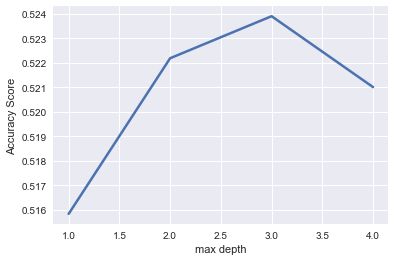

In [142]:
# Using different max_depth and applying kFold CV and eXBoost
# params = {'n_estimators': 1000, 'subsample': 0.5, 'learning_rate': 0.01}
params = {'subsample': 0.5, 'learning_rate': 0.01}
kfold = KFold(n_splits=5)
accs = []
max_depth_list = []
max_depths = range(1, 5)
for max_depth in max_depths:
    k_accs = []
    for train, test in kfold.split(X):
        Xtrain, Xtest, ytrain, ytest = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
# if something goes wrong with the split, check option of .values()
        clf = xgb.XGBClassifier(max_depth=max_depth, n_estimators=1000, **params)
        clf.fit(Xtrain, ytrain)
        ypred = clf.predict(Xtest)
        k_accs.append(accuracy_score(ytest, ypred))
        max_depth_list.append(max_depth)
    accs.append(np.mean(k_accs))
# plot the accuracies as a function of max_depth

print(classification_report(ytest, ypred))
plt.plot(max_depths, accs, linewidth=2.5)
plt.xlabel("max depth")
plt.ylabel("Accuracy Score")

# the more n_estimators, the better, so far the best was around 970


In [44]:
import sys
print(sys.version)

3.4.5 |Anaconda 4.3.0 (64-bit)| (default, Jul  5 2016, 14:53:07) [MSC v.1600 64 bit (AMD64)]


In [84]:
X.head()

,Open,Volume,pct_change_lag2,pct_change_lag3,direction_lag1,direction_lag2,lr3_10_lag1,lr3_10_lag2,lr3_10_lag3,lr3_10signal_lag1,lr3_10signal_lag2,lr3_10signal_lag3,hist_lag1,hist_lag2,hist_lag3
Date,,,,,,,,,,,,,,,
2010-04-06,1186.010010,4086180000,0.015401,0.012077,1.0,1.0,6.175325,4.206010,3.806344,8.094253,8.711815,9.503502,-1.918928,-4.505805,-5.697158
2010-04-07,1188.229980,5101430000,0.009626,0.017111,1.0,1.0,10.482300,6.175325,4.206010,7.831501,8.094253,8.711815,2.650799,-1.918928,-4.505805
2010-04-08,1181.750000,4726970000,-0.004202,0.003692,0.0,1.0,11.104301,10.482300,6.175325,7.723041,7.831501,8.094253,3.381260,2.650799,-1.918928
2010-04-09,1187.469971,4511570000,-0.002522,-0.000842,1.0,0.0,8.898970,11.104301,10.482300,7.541851,7.723041,7.831501,1.357119,3.381260,2.650799
2010-04-12,1194.939941,4607090000,0.010081,0.004145,1.0,1.0,7.678320,8.898970,11.104301,7.242829,7.541851,7.723041,0.435491,1.357119,3.381260


In [103]:
clf = xgb.XGBClassifier(max_depth=1, n_estimators=100)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
accuracy_score(ytest, ypred)


0.51873198847262247

In [126]:
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

accuracy_score(ytest, ypred)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [87]:
Xtrain.head()

,Open,Volume,pct_change_lag2,pct_change_lag3,direction_lag1,direction_lag2,lr3_10_lag1,lr3_10_lag2,lr3_10_lag3,lr3_10signal_lag1,lr3_10signal_lag2,lr3_10signal_lag3,hist_lag1,hist_lag2,hist_lag3
Date,,,,,,,,,,,,,,,
2010-04-06,1186.010010,4086180000,0.015401,0.012077,1.0,1.0,6.175325,4.206010,3.806344,8.094253,8.711815,9.503502,-1.918928,-4.505805,-5.697158
2010-04-07,1188.229980,5101430000,0.009626,0.017111,1.0,1.0,10.482300,6.175325,4.206010,7.831501,8.094253,8.711815,2.650799,-1.918928,-4.505805
2010-04-08,1181.750000,4726970000,-0.004202,0.003692,0.0,1.0,11.104301,10.482300,6.175325,7.723041,7.831501,8.094253,3.381260,2.650799,-1.918928
2010-04-09,1187.469971,4511570000,-0.002522,-0.000842,1.0,0.0,8.898970,11.104301,10.482300,7.541851,7.723041,7.831501,1.357119,3.381260,2.650799
2010-04-12,1194.939941,4607090000,0.010081,0.004145,1.0,1.0,7.678320,8.898970,11.104301,7.242829,7.541851,7.723041,0.435491,1.357119,3.381260


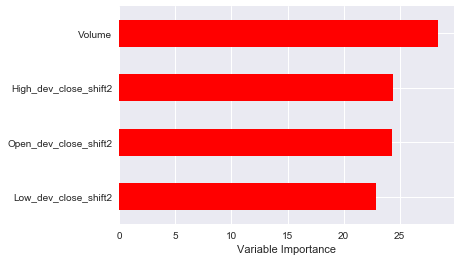

In [140]:
Importance = pd.DataFrame({'Importance':clf.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None